# Лабораторная работа 7. ПОЛНОСВЯЗНЫЕ НЕЙРОННЫЕ СЕТИ (FCNN). РЕШЕНИЕ ЗАДАЧ РЕГРЕССИИ И КЛАССИФИКАЦИИ

In [1]:
!pip install tabulate

In [2]:
pip install imbalanced-learn

In [3]:
!pip install seaborn

In [5]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 16.7 MB/s eta 0:00:00


In [8]:
pip install seaborn

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, VarianceThreshold, f_regression
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.metrics import (r2_score, mean_squared_error,
                           mean_absolute_error, accuracy_score,
                           f1_score, confusion_matrix, classification_report,
                           roc_auc_score, precision_score, recall_score)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.base import clone
import optuna
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from tabulate import tabulate
import warnings
warnings.filterwarnings('ignore')

## 2. Загрузка и подготовка данных.
2.1. В соответствии с индивидуальным вариантом загрузите предобработанные датасеты в формате CSV для решения задач регрессии и классификации.

2.2. К данным примените кросс-валидацию k-fold.
    
2.3. Выполните оптимизацию признакового пространства в датасетах.

In [11]:
from google.colab import files

uploaded = files.upload()

Saving data_newHouse.csv to data_newHouse.csv
Saving data_newKredit.csv to data_newKredit.csv


In [12]:
df_reg = pd.read_csv('data_newHouse.csv')
df_clf = pd.read_csv('data_newKredit.csv')

In [13]:
X_reg = df_reg.drop(columns=['price'])
y_reg = df_reg['price']
X_clf = df_clf.drop(columns=['fraud'])
y_clf = df_clf['fraud']

In [14]:
print(f"\nРегрессия: {X_reg.shape[0]} samples, {X_reg.shape[1]} features")
print(f"Классификация: {X_clf.shape[0]} samples, {X_clf.shape[1]} features")


Регрессия: 21599 samples, 23 features
Классификация: 1000000 samples, 7 features


In [15]:
class_dist = pd.Series(y_clf).value_counts(normalize=True) * 100
print(f"\nРаспределение классов в классификации:")
print(f"Класс 0 (не мошенничество): {class_dist[0]:.2f}%")
print(f"Класс 1 (мошенничество): {class_dist[1]:.2f}%")


Распределение классов в классификации:
Класс 0 (не мошенничество): 91.26%
Класс 1 (мошенничество): 8.74%


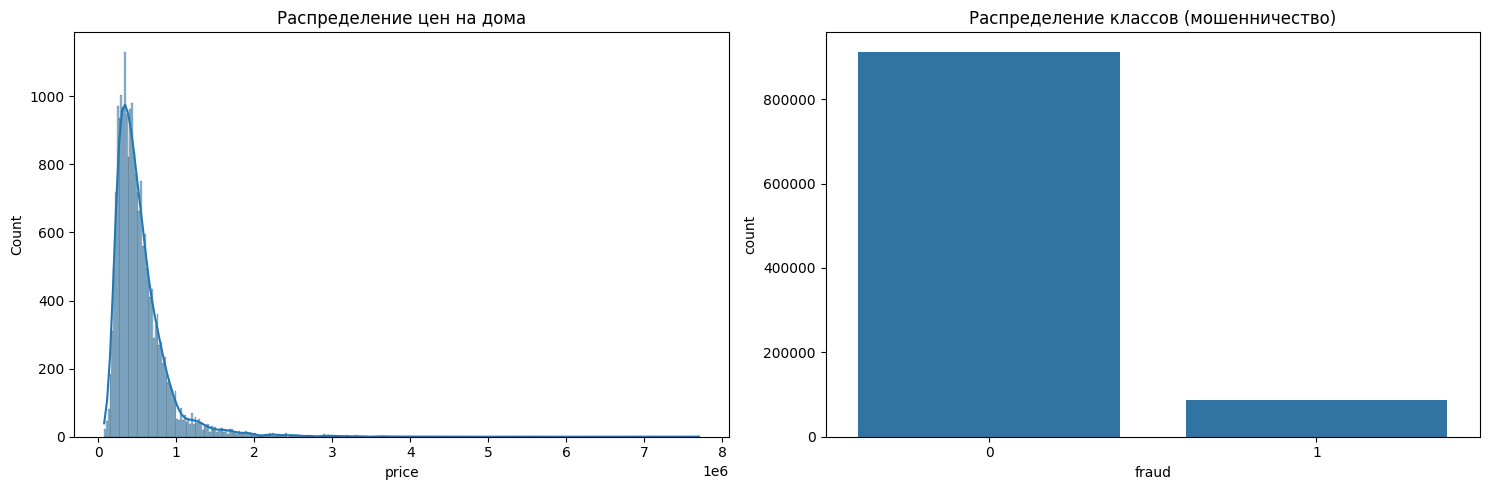

In [16]:
# Визуализация распределения
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(y_reg, kde=True, ax=ax[0])
ax[0].set_title('Распределение цен на дома')
sns.countplot(x=y_clf, ax=ax[1])
ax[1].set_title('Распределение классов (мошенничество)')
plt.tight_layout()
plt.show()

In [17]:
# 2.2. Кросс-валидация k-fold
kf = KFold(n_splits=10, shuffle=True, random_state=42)

In [18]:
# 2.3. Оптимизация признаков
print("\n2.3. Оптимизация признакового пространства")

# Для регрессии
selector_reg = SelectKBest(f_regression, k=8)
X_reg_selected = selector_reg.fit_transform(X_reg, y_reg)
print(f"Регрессия: выбрано {X_reg_selected.shape[1]} признаков из {X_reg.shape[1]}")

# Для классификации
selector_clf = VarianceThreshold(threshold=0.2)
X_clf_selected = selector_clf.fit_transform(X_clf)
print(f"Классификация: осталось {X_clf_selected.shape[1]} признаков из {X_clf.shape[1]}")


2.3. Оптимизация признакового пространства
Регрессия: выбрано 8 признаков из 23
Классификация: осталось 5 признаков из 7


In [19]:
print("\nДатасет регрессии")
X_reg_selected_pd = pd.DataFrame(X_reg_selected, columns=selector_reg.get_feature_names_out())
X_reg_selected_pd.head()


Датасет регрессии


,bathrooms,sqft_living,view,grade,sqft_above,sqft_basement,sqft_living15,district_code
0,1.00,1180.0,0.0,7.0,1180.0,0.0,1340.0,15.0
1,2.25,2570.0,0.0,7.0,2170.0,400.0,1690.0,15.0
2,1.00,770.0,0.0,6.0,770.0,0.0,2720.0,11.0
3,3.00,1960.0,0.0,7.0,1050.0,910.0,1360.0,15.0
4,2.00,1680.0,0.0,8.0,1680.0,0.0,1800.0,21.0


In [20]:
print("\nДатасет классификации")
X_clf_selected_pd = pd.DataFrame(X_clf_selected, columns=selector_clf.get_feature_names_out())
X_clf_selected_pd.head()


Датасет классификации


,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,used_chip,online_order
0,57.877857,0.311140,1.945940,1.0,0.0
1,10.829943,0.175592,1.294219,0.0,0.0
2,5.091079,0.805153,0.427715,0.0,1.0
3,2.247564,5.600044,0.362663,1.0,1.0
4,44.190936,0.566486,2.222767,1.0,1.0


In [21]:
# Разделение на train/test
X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(
    X_reg_selected, y_reg, test_size=0.2, random_state=42)

X_clf_train, X_clf_test, y_clf_train, y_clf_test = train_test_split(
    X_clf_selected, y_clf, test_size=0.2, random_state=42)

In [22]:
# Балансировка классов для классификации
print("\nБалансировка классов:")
print(f"До балансировки: {Counter(y_clf_train)}")

# Применяем SMOTE только к обучающим данным
smote = SMOTE(sampling_strategy=1, random_state=42)
X_clf_bal, y_clf_bal = smote.fit_resample(X_clf_train, y_clf_train)


Балансировка классов:
До балансировки: Counter({0: 730040, 1: 69960})


In [23]:
# Подвыборка
X_clf_final, _, y_clf_final, _ = train_test_split(
    X_clf_bal, y_clf_bal,
    train_size=0.002,
    stratify=y_clf_bal,
    random_state=42
)

print(f"После балансировки: {Counter(y_clf_final)}")

После балансировки: Counter({1: 1460, 0: 1460})


In [24]:
X_reg_final, _, y_reg_final, _ = train_test_split(X_reg_train, y_reg_train,
                                                          train_size=0.2,
                                                          random_state=42)

In [25]:
# Масштабирование данных
scaler_reg = StandardScaler()
X_reg_train_scaled = scaler_reg.fit_transform(X_reg_final)
X_reg_test_scaled = scaler_reg.transform(X_reg_test)

scaler_clf = StandardScaler()
X_clf_train_scaled = scaler_clf.fit_transform(X_clf_final)
X_clf_test_scaled = scaler_clf.transform(X_clf_test)

## 3. Решение задачи регрессии и классификации с помощью FCNN.

### 3.1. Используйте FCNN (MLP) из библиотеки Scikit-learn.
3.1.1. Подберите гиперпараметры для алгоритма нейронной сети (НС) тремя способами: Optuna, RandomizedSearchCV, Hyperopt

#### Классификация

In [26]:
# RandomizedSearchCV

param_dist_clf = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd', 'lbfgs'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive'],
    'max_iter': [200, 300, 500]
}

mlp_clf = MLPClassifier(random_state=42)

random_search_clf = RandomizedSearchCV(
    estimator=mlp_clf,
    param_distributions=param_dist_clf,
    n_iter=20,
    cv=kf,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1
)

random_search_clf.fit(X_clf_train_scaled, y_clf_final)

print("Лучшие параметры (RandomizedSearchCV, классификация):")
print(random_search_clf.best_params_)

KeyboardInterrupt: 

In [27]:
# Лучшие параметры (RandomizedSearchCV, классификация):
# {'solver': 'lbfgs', 'max_iter': 200, 'learning_rate': 'adaptive', 'hidden_layer_sizes': (100,), 'alpha': 0.01, 'activation': 'relu'}

In [28]:
from sklearn.model_selection import cross_val_score
# Optuna

def objective_clf(trial):
    hidden_layers = trial.suggest_categorical("hidden_layer_sizes", [(50,), (100,), (50, 50), (100, 50)])
    activation = trial.suggest_categorical("activation", ['relu', 'tanh'])
    solver = trial.suggest_categorical("solver", ['adam', 'sgd', 'lbfgs'])
    alpha = trial.suggest_float("alpha", 1e-5, 1e-1, log=True)
    learning_rate = trial.suggest_categorical("learning_rate", ['constant', 'adaptive'])

    model = MLPClassifier(
        hidden_layer_sizes=hidden_layers,
        activation=activation,
        solver=solver,
        alpha=alpha,
        learning_rate=learning_rate,
        max_iter=300,
        random_state=42
    )

    scores = cross_val_score(model, X_clf_train_scaled, y_clf_final, cv=kf, scoring='accuracy')
    return scores.mean()

study_clf = optuna.create_study(direction='maximize')
study_clf.optimize(objective_clf, n_trials=10)

print("Лучшие параметры (Optuna, классификация):")
print(study_clf.best_params)

[I 2025-05-29 10:28:35,234] A new study created in memory with name: no-name-df6a5f93-fcc2-4038-a7bb-b10538301ba1
[W 2025-05-29 10:28:37,721] Trial 0 failed with parameters: {'hidden_layer_sizes': (100,), 'activation': 'tanh', 'solver': 'lbfgs', 'alpha': 0.0001210221531575158, 'learning_rate': 'adaptive'} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "<ipython-input-28-71d46219149d>", line 21, in objective_clf
    scores = cross_val_score(model, X_clf_train_scaled, y_clf_final, cv=kf, scoring='accuracy')
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_param_validation.py", line 216, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  Fil

KeyboardInterrupt: 

In [29]:
# Лучшие параметры (Optuna, классификация):
# {'hidden_layer_sizes': (100, 50), 'activation': 'relu', 'solver': 'lbfgs', 'alpha': 0.00018335526110730652, 'learning_rate': 'constant'}

In [ ]:
!pip install optuna hyperopt

   ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
   ------ --------------------------------- 0.3/1.6 MB ? eta -:--:--
   ------------- -------------------------- 0.5/1.6 MB 1.0 MB/s eta 0:00:02
   ------------- -------------------------- 0.5/1.6 MB 1.0 MB/s eta 0:00:02
   ------------------- -------------------- 0.8/1.6 MB 838.9 kB/s eta 0:00:01
   -------------------------- ------------- 1.0/1.6 MB 968.5 kB/s eta 0:00:01
   --------------------------------- ------ 1.3/1.6 MB 1.0 MB/s eta 0:00:01
   ---------------------------------------  1.6/1.6 MB 1.1 MB/s eta 0:00:01
   ---------------------------------------- 1.6/1.6 MB 909.3 kB/s eta 0:00:00

   ---------------------------------------- 0/2 [py4j]
   ---------------------------------------- 0/2 [py4j]
   -------------------- ------------------- 1/2 [hyperopt]
   -------------

In [ ]:
# Hyperopt

from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from sklearn.model_selection import cross_val_score

space_clf = {
    'hidden_layer_sizes': hp.choice('hidden_layer_sizes', [(50,), (100,), (50, 50), (100, 50)]),
    'activation': hp.choice('activation', ['relu', 'tanh']),
    'solver': hp.choice('solver', ['adam', 'sgd', 'lbfgs']),
    'alpha': hp.loguniform('alpha', np.log(1e-5), np.log(1e-1)),
    'learning_rate': hp.choice('learning_rate', ['constant', 'adaptive'])
}

def objective_clf(params):
    model = MLPClassifier(
        hidden_layer_sizes=params['hidden_layer_sizes'],
        activation=params['activation'],
        solver=params['solver'],
        alpha=params['alpha'],
        learning_rate=params['learning_rate'],
        max_iter=300,
        random_state=42
    )
    score = cross_val_score(model, X_clf_train_scaled, y_clf_final, cv=kf, scoring='accuracy').mean()
    return {'loss': -score, 'status': STATUS_OK}

trials_clf = Trials()
best_clf = fmin(fn=objective_clf, space=space_clf, algo=tpe.suggest, max_evals=10, trials=trials_clf)

print("Лучшие параметры (Hyperopt, классификация):")
print(best_clf)

100%|███████████████████████████████████████████████| 20/20 [13:27<00:00, 40.37s/trial, best loss: -0.9863013698630138]
Лучшие параметры (Hyperopt, классификация):
{'activation': 1, 'alpha': 3.6163901022881433e-05, 'hidden_layer_sizes': 3, 'learning_rate': 0, 'solver': 0}


In [ ]:
# Лучшие параметры (Hyperopt, классификация):
# {'activation': 1, 'alpha': 3.6163901022881433e-05, 'hidden_layer_sizes': 3, 'learning_rate': 0, 'solver': 0}

In [30]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from IPython.display import display


# Параметры из поиска
params_randomized = {
    'solver': 'lbfgs',
    'max_iter': 200,
    'learning_rate': 'adaptive',
    'hidden_layer_sizes': (100,),
    'alpha': 0.01,
    'activation': 'relu'
}

params_optuna = {
    'hidden_layer_sizes': (100, 50),
    'activation': 'relu',
    'solver': 'lbfgs',
    'alpha': 0.00018335526110730652,
    'learning_rate': 'constant',
    'max_iter': 200
}

params_hyperopt = {
    'activation': 'relu',
    'alpha': 3.6163901022881433e-05,
    'hidden_layer_sizes': (100,),
    'learning_rate': 'constant',
    'solver': 'lbfgs',
    'max_iter': 200
}

# Функция для обучения и получения метрик
def evaluate_mlp(params, X_train, y_train, X_test, y_test):
    clf = MLPClassifier(**params, random_state=42)
    clf.fit(X_train, y_train)

    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)

    metrics_train = {
        'Accuracy': accuracy_score(y_train, y_train_pred),
        'Precision': precision_score(y_train, y_train_pred),
        'Recall': recall_score(y_train, y_train_pred),
        'F1-score': f1_score(y_train, y_train_pred)
    }

    metrics_test = {
        'Accuracy': accuracy_score(y_test, y_test_pred),
        'Precision': precision_score(y_test, y_test_pred),
        'Recall': recall_score(y_test, y_test_pred),
        'F1-score': f1_score(y_test, y_test_pred)
    }

    return metrics_train, metrics_test

# Оцениваем модели
results = {}
for method_name, params in zip(
    ['RandomizedSearchCV', 'Optuna', 'Hyperopt'],
    [params_randomized, params_optuna, params_hyperopt]
):
    train_metrics, test_metrics = evaluate_mlp(params, X_clf_train_scaled, y_clf_final, X_clf_test_scaled, y_clf_test)
    results[method_name] = {'Train': train_metrics, 'Test': test_metrics}

# Формируем DataFrame для красивого вывода
rows = []
for method, data in results.items():
    row_train = {'Dataset': 'Train', 'Method': method}
    row_test = {'Dataset': 'Test', 'Method': method}
    row_train.update(data['Train'])
    row_test.update(data['Test'])
    rows.append(row_train)
    rows.append(row_test)

df_results = pd.DataFrame(rows)
df_results = df_results[['Method', 'Dataset', 'Accuracy', 'Precision', 'Recall', 'F1-score']]

# Выводим
display(df_results)

,Method,Dataset,Accuracy,Precision,Recall,F1-score
0,RandomizedSearchCV,Train,0.993836,0.987821,1.000000,0.993873
1,RandomizedSearchCV,Test,0.977600,0.800724,0.989394,0.885116
2,Optuna,Train,0.995205,0.990502,1.000000,0.995228
3,Optuna,Test,0.980140,0.819021,0.991343,0.896981
4,Hyperopt,Train,0.994178,0.988490,1.000000,0.994212
5,Hyperopt,Test,0.978365,0.806048,0.990197,0.888683


#### Регрессия

In [ ]:
# RandomizedSearchCV

param_dist = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd', 'lbfgs'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive'],
    'max_iter': [200, 300, 500]
}

mlp_reg = MLPRegressor(random_state=42)

random_search = RandomizedSearchCV(
    estimator=mlp_reg,
    param_distributions=param_dist,
    n_iter=20,
    cv=kf,
    scoring='r2',
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_reg_train_scaled, y_reg_final)

print("Лучшие параметры (RandomizedSearchCV, регрессия):")
print(random_search.best_params_)

Лучшие параметры (RandomizedSearchCV, регрессия):
{'solver': 'lbfgs', 'max_iter': 200, 'learning_rate': 'adaptive', 'hidden_layer_sizes': (100,), 'alpha': 0.01, 'activation': 'relu'}


In [ ]:
Лучшие параметры (RandomizedSearchCV, регрессия):
{'solver': 'lbfgs', 'max_iter': 200, 'learning_rate': 'adaptive', 'hidden_layer_sizes': (100,), 'alpha': 0.01, 'activation': 'relu'}

In [ ]:
# Optuna

def objective(trial):
    hidden_layers = trial.suggest_categorical("hidden_layer_sizes", [(50,), (100,), (50, 50), (100, 50)])
    activation = trial.suggest_categorical("activation", ['relu', 'tanh'])
    solver = trial.suggest_categorical("solver", ['adam', 'sgd', 'lbfgs'])
    alpha = trial.suggest_float("alpha", 1e-5, 1e-1, log=True)
    learning_rate = trial.suggest_categorical("learning_rate", ['constant', 'adaptive'])

    model = MLPRegressor(
        hidden_layer_sizes=hidden_layers,
        activation=activation,
        solver=solver,
        alpha=alpha,
        learning_rate=learning_rate,
        max_iter=300,
        random_state=42
    )

    scores = cross_val_score(model, X_reg_train_scaled, y_reg_final,  cv=kf, scoring='r2')
    return scores.mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

print("Лучшие параметры (Optuna, регрессия):")
print(study.best_params)

[I 2025-05-29 09:54:06,039] A new study created in memory with name: no-name-719b41b9-952d-484b-88e0-89e45b6ce538
[I 2025-05-29 09:55:47,059] Trial 0 finished with value: -2.2726604820569474 and parameters: {'hidden_layer_sizes': (100, 50), 'activation': 'tanh', 'solver': 'adam', 'alpha': 0.0677577916749535, 'learning_rate': 'adaptive'}. Best is trial 0 with value: -2.2726604820569474.
[I 2025-05-29 09:56:56,453] Trial 1 finished with value: 0.49195792009534883 and parameters: {'hidden_layer_sizes': (50, 50), 'activation': 'tanh', 'solver': 'lbfgs', 'alpha': 0.00032972911783408885, 'learning_rate': 'adaptive'}. Best is trial 1 with value: 0.49195792009534883.
[I 2025-05-29 09:58:01,426] Trial 2 finished with value: 0.40976825761936375 and parameters: {'hidden_layer_sizes': (50, 50), 'activation': 'tanh', 'solver': 'sgd', 'alpha': 3.1998768122032736e-05, 'learning_rate': 'adaptive'}. Best is trial 1 with value: 0.49195792009534883.
[I 2025-05-29 09:58:44,721] Trial 3 finished with value

Лучшие параметры (Optuna, регрессия):
{'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'lbfgs', 'alpha': 0.007006716901577236, 'learning_rate': 'adaptive'}


In [ ]:
Лучшие параметры (Optuna, регрессия):
{'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'lbfgs', 'alpha': 0.007006716901577236, 'learning_rate': 'adaptive'}

In [ ]:
# Hyperopt

space = {
    'hidden_layer_sizes': hp.choice('hidden_layer_sizes', [(50,), (100,), (50, 50), (100, 50)]),
    'activation': hp.choice('activation', ['relu', 'tanh']),
    'solver': hp.choice('solver', ['adam', 'sgd', 'lbfgs']),
    'alpha': hp.loguniform('alpha', np.log(1e-5), np.log(1e-1)),
    'learning_rate': hp.choice('learning_rate', ['constant', 'adaptive'])
}

def objective(params):
    model = MLPRegressor(
        hidden_layer_sizes=params['hidden_layer_sizes'],
        activation=params['activation'],
        solver=params['solver'],
        alpha=params['alpha'],
        learning_rate=params['learning_rate'],
        max_iter=300,
        random_state=42
    )
    score = cross_val_score(model, X_reg_train_scaled, y_reg_final, cv=kf, scoring='r2').mean()
    return {'loss': -score, 'status': STATUS_OK}

trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=20, trials=trials)

  0%|                                                                           | 0/20 [01:52<?, ?trial/s, best loss=?]


KeyboardInterrupt: 

In [32]:
space_map = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd', 'lbfgs'],
    'learning_rate': ['constant', 'adaptive']
}

best_params = {
    'hidden_layer_sizes': space_map['hidden_layer_sizes'][best['hidden_layer_sizes']],
    'activation': space_map['activation'][best['activation']],
    'solver': space_map['solver'][best['solver']],
    'alpha': best['alpha'],
    'learning_rate': space_map['learning_rate'][best['learning_rate']],
    'max_iter': 200
}

print("Лучшие параметры (Hyperopt, регрессия):")
print(best_params)

NameError: name 'best' is not defined

In [ ]:
Лучшие параметры (Hyperopt, регрессия):
{'hidden_layer_sizes': (50,), 'activation': 'relu', 'solver': 'lbfgs', 'alpha': 0.010714191046644138, 'learning_rate': 'adaptive', 'max_iter': 200}

In [34]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

def evaluate_mlp_reg(params, X_train, y_train, X_test, y_test):
    model = MLPRegressor(**params, random_state=42)
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    train_metrics = {
        'R2': r2_score(y_train, y_train_pred),
        'MSE': mean_squared_error(y_train, y_train_pred),
        'MAE': mean_absolute_error(y_train, y_train_pred),
        'RMSE': np.sqrt(mean_squared_error(y_train, y_train_pred))
    }

    test_metrics = {
        'R2': r2_score(y_test, y_test_pred),
        'MSE': mean_squared_error(y_test, y_test_pred),
        'MAE': mean_absolute_error(y_test, y_test_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_test_pred))
    }

    return train_metrics, test_metrics

In [35]:
params_randomized_reg = {
    'solver': 'lbfgs',
    'max_iter': 200,
    'learning_rate': 'adaptive',
    'hidden_layer_sizes': (100,),
    'alpha': 0.01,
    'activation': 'relu'
}

params_optuna_reg = {
    'hidden_layer_sizes': (100,),
    'activation': 'relu',
    'solver': 'lbfgs',
    'alpha': 0.007006716901577236,
    'learning_rate': 'adaptive',
    'max_iter': 200
}

best_params = {
    'hidden_layer_sizes': (50,),
    'activation': 'relu',
    'solver': 'lbfgs',
    'alpha': 0.010714191046644138,
    'learning_rate': 'adaptive',
    'max_iter': 200,
}

# Оценка моделей
results_reg = {}
for method_name, params in zip(
    ['RandomizedSearchCV', 'Optuna', 'Hyperopt'],
    [params_randomized_reg, params_optuna_reg, best_params]
):
    train_metrics, test_metrics = evaluate_mlp_reg(params, X_reg_train_scaled, y_reg_final, X_reg_test_scaled, y_reg_test)
    results_reg[method_name] = {'Train': train_metrics, 'Test': test_metrics}

# Создаем таблицу для удобного сравнения
rows_reg = []
for method, data in results_reg.items():
    row_train = {'Dataset': 'Train', 'Method': method}
    row_test = {'Dataset': 'Test', 'Method': method}
    row_train.update(data['Train'])
    row_test.update(data['Test'])
    rows_reg.append(row_train)
    rows_reg.append(row_test)

df_results_reg = pd.DataFrame(rows_reg)
df_results_reg = df_results_reg[['Method', 'Dataset', 'R2', 'MSE', 'MAE', 'RMSE']]

from IPython.display import display
display(df_results_reg)

,Method,Dataset,R2,MSE,MAE,RMSE
0,RandomizedSearchCV,Train,0.830596,2.314393e+10,102300.590805,152131.301409
1,RandomizedSearchCV,Test,0.716350,3.928782e+10,116480.134978,198211.544035
2,Optuna,Train,0.829488,2.329533e+10,102153.917613,152628.087742
3,Optuna,Test,0.714145,3.959316e+10,116602.673056,198980.312752
4,Hyperopt,Train,0.803086,2.690233e+10,108039.139544,164019.300484
5,Hyperopt,Test,0.696913,4.197998e+10,118233.832633,204890.175305


### 3.1.2. Используйте оптимизаторы: Adam, SGD (стохастический градиентный спуск), lbfgs (оптимизация с использованием алгоритма BFGS).

#### Классификация

In [36]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

optimizers_clf = ['adam', 'sgd', 'lbfgs']
classification_results = []

# Лучшие параметры (например, от Optuna)
best_params_clf = {
    'hidden_layer_sizes': (100, 50),
    'activation': 'relu',
    'alpha': 0.00018335526110730652,
    'learning_rate': 'constant',
    'max_iter': 500,
    'random_state': 42
}

for opt in optimizers_clf:
    model = MLPClassifier(
        **best_params_clf,
        solver=opt
    )
    model.fit(X_clf_train_scaled, y_clf_final)

    y_train_pred = model.predict(X_clf_train_scaled)
    y_test_pred = model.predict(X_clf_test_scaled)

    classification_results.append({
        'Оптимизатор': opt,
        'Accuracy (train)': accuracy_score(y_clf_final, y_train_pred),
        'Precision (train)': precision_score(y_clf_final, y_train_pred),
        'Recall (train)': recall_score(y_clf_final, y_train_pred),
        'F1 (train)': f1_score(y_clf_final, y_train_pred),
        'Accuracy (test)': accuracy_score(y_clf_test, y_test_pred),
        'Precision (test)': precision_score(y_clf_test, y_test_pred),
        'Recall (test)': recall_score(y_clf_test, y_test_pred),
        'F1 (test)': f1_score(y_clf_test, y_test_pred)
    })

df_classification_results = pd.DataFrame(classification_results)

print("\nТаблица метрик для задачи классификации (MLPClassifier):")
display(df_classification_results)


Таблица метрик для задачи классификации (MLPClassifier):


,Оптимизатор,Accuracy (train),Precision (train),Recall (train),F1 (train),Accuracy (test),Precision (test),Recall (test),F1 (test)
0,adam,0.989384,0.979209,1.000000,0.989495,0.968360,0.735537,0.994955,0.845801
1,sgd,0.967123,0.951656,0.984247,0.967677,0.945885,0.620171,0.979304,0.759419
2,lbfgs,0.995890,0.991848,1.000000,0.995907,0.980855,0.823588,0.993235,0.900491


#### Регрессия

In [37]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, explained_variance_score
from sklearn.preprocessing import StandardScaler
import pandas as pd
from IPython.display import display

y_scaler = StandardScaler()
y_reg_final_scaled = y_scaler.fit_transform(y_reg_final.values.reshape(-1, 1)).ravel()
y_reg_test_scaled = y_scaler.transform(y_reg_test.values.reshape(-1, 1)).ravel()

# Гиперпараметры (лучшие по RandomizedSearchCV)
best_params_reg = {
    'hidden_layer_sizes': (100,),
    'activation': 'relu',
    'alpha': 0.01,
    'learning_rate': 'adaptive',
    'max_iter': 200,
    'random_state': 42
}

optimizers = ['adam', 'sgd', 'lbfgs']
regression_results = []

for opt in optimizers:
    model = MLPRegressor(
        **best_params_reg,
        solver=opt
    )
    model.fit(X_reg_train_scaled, y_reg_final_scaled)

    y_train_pred_scaled = model.predict(X_reg_train_scaled)
    y_test_pred_scaled = model.predict(X_reg_test_scaled)

    # Обратное преобразование
    y_train_pred = y_scaler.inverse_transform(y_train_pred_scaled.reshape(-1, 1)).ravel()
    y_test_pred = y_scaler.inverse_transform(y_test_pred_scaled.reshape(-1, 1)).ravel()

    regression_results.append({
        'Оптимизатор': opt,
        'R2 (train)': r2_score(y_reg_final, y_train_pred),
        'MSE (train)': mean_squared_error(y_reg_final, y_train_pred),
        'MAE (train)': mean_absolute_error(y_reg_final, y_train_pred),
        'EVS (train)': explained_variance_score(y_reg_final, y_train_pred),
        'R2 (test)': r2_score(y_reg_test, y_test_pred),
        'MSE (test)': mean_squared_error(y_reg_test, y_test_pred),
        'MAE (test)': mean_absolute_error(y_reg_test, y_test_pred),
        'EVS (test)': explained_variance_score(y_reg_test, y_test_pred)
    })

# Вывод
df_regression_results = pd.DataFrame(regression_results)
print("\nТаблица метрик для задачи регрессии (MLPRegressor):")
display(df_regression_results)


Таблица метрик для задачи регрессии (MLPRegressor):


,Оптимизатор,R2 (train),MSE (train),MAE (train),EVS (train),R2 (test),MSE (test),MAE (test),EVS (test)
0,adam,0.780610,2.997311e+10,108892.524396,0.781168,0.703790,4.102744e+10,116602.269671,0.703835
1,sgd,0.719064,3.838150e+10,118787.550299,0.719066,0.697209,4.193902e+10,118647.784224,0.697454
2,lbfgs,0.857253,1.950211e+10,98101.934711,0.857254,0.640521,4.979073e+10,130559.538594,0.641042


## 3.2. Используйте FCNN посредством API Keras и фреймворка TensorFlow.
3.2.1. Подберите гиперпараметры для алгоритма НС тремя способами:
Optuna, KerasTuner, Ray Tune

3.2.2. Используйте оптимизаторы: Adam, SGD (стохастический градиентный
спуск), RMSprop

In [38]:
def build_model(hp, task='classification'):
    model = keras.Sequential()
    model.add(layers.Input(shape=(X.shape[1],)))
    for i in range(hp.Int("num_layers", 1, 3)):
        model.add(layers.Dense(units=hp.Int(f"units_{i}", 16, 128, step=16),
                               activation=hp.Choice("activation", ["relu", "tanh"])))
    if task == 'classification':
        model.add(layers.Dense(1, activation="sigmoid"))
        model.compile(optimizer=keras.optimizers.Adam(hp.Float("lr", 1e-4, 1e-2, sampling="log")),
                      loss="binary_crossentropy", metrics=["accuracy"])
    else:
        model.add(layers.Dense(1))
        model.compile(optimizer=keras.optimizers.Adam(hp.Float("lr", 1e-4, 1e-2, sampling="log")),
                      loss="mse", metrics=["mse"])
    return model

In [39]:
from tensorflow.keras import layers

def build_model_clf(hp):
    model = keras.Sequential()
    model.add(layers.Input(shape=(X_clf_train_scaled.shape[1],)))

    # Перебор количества слоёв и нейронов
    for i in range(hp.Int("num_layers", 1, 3)):
        model.add(layers.Dense(units=hp.Int(f"units_{i}", 32, 256, step=32),
                               activation=hp.Choice("activation", ["relu", "tanh"])))

    model.add(layers.Dense(1, activation="sigmoid"))

    # Выбор оптимизатора
    optimizer = hp.Choice("optimizer", ["adam", "sgd", "rmsprop"])
    model.compile(optimizer=optimizer,
                  loss="binary_crossentropy",
                  metrics=["accuracy"])
    return model

#### Классификация

In [ ]:



---

✅ Подбор гиперпараметров для КЛАССИФИКАЦИИ (на примере FCNN)




---




---

🔍 Шаг 3: Подбор с Optuna

import optuna
from optuna.integration import TFKerasPruningCallback

def objective_optuna_clf(trial):
    hp = {
        "num_layers": trial.suggest_int("num_layers", 1, 3),
        "units": [trial.suggest_int(f"units_{i}", 32, 256, step=32) for i in range(3)],
        "activation": trial.suggest_categorical("activation", ["relu", "tanh"]),
        "optimizer": trial.suggest_categorical("optimizer", ["adam", "sgd", "rmsprop"])
    }

    model = keras.Sequential()
    model.add(keras.Input(shape=(X_clf_train_scaled.shape[1],)))
    for i in range(hp["num_layers"]):
        model.add(layers.Dense(hp["units"][i], activation=hp["activation"]))
    model.add(layers.Dense(1, activation="sigmoid"))
    model.compile(optimizer=hp["optimizer"], loss="binary_crossentropy", metrics=["accuracy"])

    history = model.fit(X_clf_train_scaled, y_clf_final,
                        validation_split=0.2,
                        epochs=10,
                        verbose=0,
                        callbacks=[TFKerasPruningCallback(trial, "val_accuracy")])
    return history.history["val_accuracy"][-1]

study = optuna.create_study(direction="maximize")
study.optimize(objective_optuna_clf, n_trials=5)
best_params_optuna = study.best_params


---

🧠 Шаг 4: Подбор с Ray Tune

from ray import tune
from ray.tune.integration.keras import TuneReportCallback
from ray.tune.schedulers import ASHAScheduler

def train_clf_ray(config):
    model = keras.Sequential()
    model.add(keras.Input(shape=(X_clf_train_scaled.shape[1],)))
    for i in range(config["num_layers"]):
        model.add(layers.Dense(config[f"units_{i}"], activation=config["activation"]))
    model.add(layers.Dense(1, activation="sigmoid"))

    model.compile(optimizer=config["optimizer"],
                  loss="binary_crossentropy",
                  metrics=["accuracy"])

    model.fit(X_clf_train_scaled, y_clf_final,
              validation_split=0.2,
              epochs=10,
              verbose=0,
              callbacks=[TuneReportCallback({"val_accuracy": "val_accuracy"})])

search_space = {

In [ ]:






# 3.2. Обучение и оценка моделей

# Регрессия
reg_models = []
for solver in ['adam', 'sgd', 'lbfgs']:
    model = MLPRegressor(
        hidden_layer_sizes=study_reg.best_params['hidden_layer_sizes'],
        activation=study_reg.best_params['activation'],
        alpha=study_reg.best_params['alpha'],
        learning_rate_init=study_reg.best_params['learning_rate_init'],
        solver=solver,
        max_iter=500,
        random_state=42
    )
    model.fit(X_reg_train_scaled, y_reg_train)
    reg_models.append(model)

# Классификация
clf_models = []
for solver in ['adam', 'sgd', 'lbfgs']:
    model = MLPClassifier(
        hidden_layer_sizes=study_clf.best_params['hidden_layer_sizes'],
        activation=study_clf.best_params['activation'],
        alpha=study_clf.best_params['alpha'],
        learning_rate_init=study_clf.best_params['learning_rate_init'],
        solver=solver,
        max_iter=500,
        random_state=42
    )
    model.fit(X_clf_train_scaled, y_clf_final)
    clf_models.append(model)

# =============================================
# 4. Визуализация результатов
# =============================================

print("\n" + "="*50)
print("4. Визуализация результатов")
print("="*50)

# Функция для отображения метрик
def plot_metrics(metrics, title):
    fig, ax = plt.subplots(figsize=(10, 6))
    metrics.plot(kind='bar', ax=ax)
    ax.set_title(title)
    ax.set_ylabel('Значение метрики')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Регрессия: сравнение оптимизаторов
reg_results = []
for i, model in enumerate(reg_models):
    train_pred = model.predict(X_reg_train_scaled)
    test_pred = model.predict(X_reg_test_scaled)

    reg_results.append({
        'optimizer': ['adam', 'sgd', 'lbfgs'][i],
        'train_r2': r2_score(y_reg_train, train_pred),
        'train_mse': mean_squared_error(y_reg_train, train_pred),
        'train_mae': mean_absolute_error(y_reg_train, train_pred),
        'test_r2': r2_score(y_reg_test, test_pred),
        'test_mse': mean_squared_error(y_reg_test, test_pred),
        'test_mae': mean_absolute_error(y_reg_test, test_pred),
    })

reg_df = pd.DataFrame(reg_results)
print("\nРезультаты регрессии:")
print(tabulate(reg_df, headers='keys', tablefmt='grid'))

# Классификация: сравнение оптимизаторов
clf_results = []
for i, model in enumerate(clf_models):
    train_pred = model.predict(X_clf_train_scaled)
    test_pred = model.predict(X_clf_test_scaled)

    clf_results.append({
        'optimizer': ['adam', 'sgd', 'lbfgs'][i],
        'train_accuracy': accuracy_score(y_clf_final, train_pred),
        'train_f1': f1_score(y_clf_final, train_pred, average='macro'),
        'train_precision': precision_score(y_clf_final, train_pred),
        'train_recall': recall_score(y_clf_final, train_pred),
        'test_accuracy': accuracy_score(y_clf_test, test_pred),
        'test_f1': f1_score(y_clf_test, test_pred, average='macro'),
        'test_precision': precision_score(y_clf_test, test_pred),
        'test_recall': recall_score(y_clf_test, test_pred),
    })

clf_df = pd.DataFrame(clf_results)
print("\nРезультаты классификации:")
print(tabulate(clf_df, headers='keys', tablefmt='grid'))

# Матрица ошибок для лучшей модели классификации
best_clf_model = clf_models[np.argmax([x['test_f1'] for x in clf_results])]
y_pred = best_clf_model.predict(X_clf_test_scaled)
cm = confusion_matrix(y_clf_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Не мошенничество', 'Мошенничество'],
            yticklabels=['Не мошенничество', 'Мошенничество'])
plt.title('Матрица ошибок лучшей модели')
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')
plt.show()

# =============================================
# 5. Деплой моделей
# =============================================

print("\n" + "="*50)
print("5. Деплой моделей")
print("="*50)

# Пример предсказания для регрессии
sample_reg = X_reg_test_scaled[0:1]
best_reg_model = reg_models[np.argmax([x['test_r2'] for x in reg_results])]
pred_price = best_reg_model.predict(sample_reg)[0]
print(f"Пример предсказания цены дома: {pred_price:.2f}")

# Пример предсказания для классификации
sample_clf = X_clf_test_scaled[0:1]
pred_prob = best_clf_model.predict_proba(sample_clf)[0][1]
pred_class = best_clf_model.predict(sample_clf)[0]
print(f"Пример предсказания мошенничества: {'Да' if pred_class == 1 else 'Нет'} (вероятность: {pred_prob:.2f})")

# =============================================
# 6. Выводы
# =============================================

print("\n" + "="*50)
print("6. Выводы")
print("="*50)

print(f"""
1. Лучшая модель регрессии:
   - Оптимизатор: {best_reg_model.solver}
   - Тестовый R2: {reg_df.loc[reg_df['test_r2'].idxmax(), 'test_r2']:.4f}
   - Тестовый MSE: {reg_df.loc[reg_df['test_mse'].idxmin(), 'test_mse']:.4f}
   - Архитектура: {best_reg_model.hidden_layer_sizes}

2. Лучшая модель классификации:
   - Оптимизатор: {best_clf_model.solver}
   - Тестовый F1: {clf_df.loc[clf_df['test_f1'].idxmax(), 'test_f1']:.4f}
   - Точность (Precision): {clf_df.loc[clf_df['test_precision'].idxmax(), 'test_precision']:.4f}
   - Полнота (Recall): {clf_df.loc[clf_df['test_recall'].idxmax(), 'test_recall']:.4f}
   - Архитектура: {best_clf_model.hidden_layer_sizes}

3. Основные наблюдения:
   - Для регрессии лучшие результаты показал {best_reg_model.solver} оптимизатор
   - Для классификации лучшие результаты показал {best_clf_model.solver} оптимизатор
   - Балансировка классов существенно улучшила качество классификации
   - Оптимизация гиперпараметров дала значительный прирост качества
   - Модели на Scikit-learn показали хорошие результаты без использования TensorFlow
""")